<a href="https://colab.research.google.com/github/Ad603-tech/Deep-Learning-Projects/blob/main/PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-bughk8m7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-bughk8m7
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


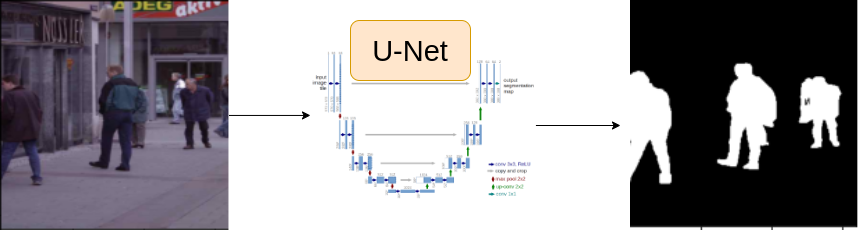

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [7]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

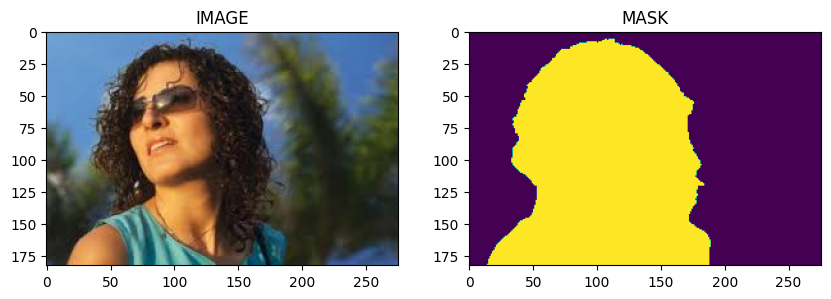

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [11]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE)], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c) -> (c, h, w)

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask



In [16]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


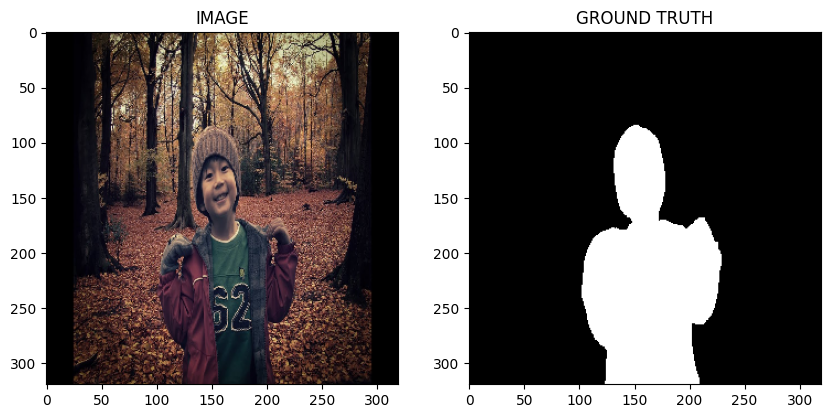

In [18]:
idx = 21
image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [21]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [22]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [24]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits



In [25]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [26]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [27]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss/ len(data_loader)

# Task 8 : Train Model

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [31]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


SAVED MODEL
Epoch : 1 Train_loss : 0.19261824836333594 Valid_loss : 0.2046339102089405


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


Epoch : 2 Train_loss : 0.17409904648860294 Valid_loss : 0.21223221719264984


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch : 3 Train_loss : 0.1582227384050687 Valid_loss : 0.23371225968003273


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED MODEL
Epoch : 4 Train_loss : 0.1338646839062373 Valid_loss : 0.1899058185517788


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 5 Train_loss : 0.18896821240584055 Valid_loss : 0.29616131633520126


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 6 Train_loss : 0.1533948188026746 Valid_loss : 0.20412935689091682


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Epoch : 7 Train_loss : 0.14991036653518677 Valid_loss : 0.1953701637685299


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 8 Train_loss : 0.14280229260524113 Valid_loss : 0.2623378485441208


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


SAVED MODEL
Epoch : 9 Train_loss : 0.12849614520867667 Valid_loss : 0.18586646392941475


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 10 Train_loss : 0.10802768270174662 Valid_loss : 0.2025849036872387


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 11 Train_loss : 0.11169081827004751 Valid_loss : 0.2592235095798969


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Epoch : 12 Train_loss : 0.11282023141781489 Valid_loss : 0.22420620545744896


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 13 Train_loss : 0.10058420995871226 Valid_loss : 0.22590215876698494


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 14 Train_loss : 0.12422583848237992 Valid_loss : 0.22018659114837646


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


Epoch : 15 Train_loss : 0.14369328667720158 Valid_loss : 0.19269088096916676


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


SAVED MODEL
Epoch : 16 Train_loss : 0.11236125081777573 Valid_loss : 0.16675859317183495


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 17 Train_loss : 0.09026472767194112 Valid_loss : 0.17529405280947685


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch : 18 Train_loss : 0.07868874222040176 Valid_loss : 0.18121138960123062


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


SAVED MODEL
Epoch : 19 Train_loss : 0.0715713473657767 Valid_loss : 0.14734162017703056


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


SAVED MODEL
Epoch : 20 Train_loss : 0.07133093203107516 Valid_loss : 0.14602772146463394


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 21 Train_loss : 0.08484338993827502 Valid_loss : 0.18485605716705322


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 22 Train_loss : 0.16017861515283585 Valid_loss : 0.28561221063137054


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 23 Train_loss : 0.14117680241664252 Valid_loss : 0.2842491790652275


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 24 Train_loss : 0.1366641864180565 Valid_loss : 0.1981472484767437


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

Epoch : 25 Train_loss : 0.11593780120213827 Valid_loss : 0.18608523160219193


# Task 9 : Inference

In [34]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

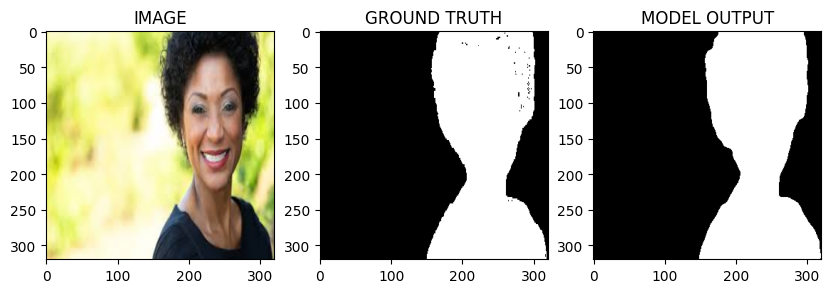

In [35]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya